<a href="https://colab.research.google.com/github/JugglingNumbers/intraday_nope_research/blob/data_clean/NOPE_results_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### created by @JugglingNumbers JugglingNumbers1@gmail.com

### **Load the data**

In [2]:
import pandas as pd
import numpy as np

In [3]:
!git clone https://github.com/The-NOPE-Project/intraday_nope_research
%cd intraday_nope_research/scripts
DATA_PATH = "/content/intraday_nope_research/processed_data/"
all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv').loc[:,['timestamp', 'C', 'P', 'netDelta', 'stockVolumeAll', 'stockVolumeBus',
                                                                  'numStockTransactions', 'NOPE_busVolume', 'NOPE_allVolume', 'spyPrice']]

Cloning into 'intraday_nope_research'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 142 (delta 58), reused 109 (delta 30), pack-reused 0
Receiving objects: 100% (142/142), 6.10 MiB | 9.97 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/intraday_nope_research/scripts


In [4]:
df = all_data.copy()
df['timestamp'] = pd.Index(pd.to_datetime(df['timestamp'])).tz_localize('US/Eastern')
df['ret'] = df['spyPrice'].pct_change().values
df['ret2'] = df['ret'].pct_change().values
df['ret3'] = df['ret2'].pct_change().values
df['nope'] = df['NOPE_busVolume'].pct_change().values
df['nope2'] = df['nope'].pct_change().values
df['nope3'] = df['nope2'].pct_change().values

strat = df.copy().set_index('timestamp')
strat.index = pd.to_datetime(strat.index)
strat['time'] = strat.index.strftime("%H:%M:%S")

### **Functions**

In [5]:
from functools import partial

def mrMask(df, nope_col, strat_col, entry, exit, stop, no_overnight_trades, alt_time_rules):
  if not alt_time_rules:
    time_rules = (df['time'] < "16:00:00") & (df['time'] > "09:30:00")
  else:
    time_rules = alt_time_rules
  adj = 1

  if (stop < entry) & (entry < exit):
    STRAT = 'LONG'
  elif (stop > entry) & (entry > exit):
    STRAT = 'SHORT'
    adj = -1
  else:
    raise AssertionError("stop > entry > exit or stop < entry < exit is required for mean reversion strategies")

  ret_mask = True #(df['ret2']<0)
  entry_mask = (adj*df[nope_col] <= adj*entry) & ret_mask & time_rules #& (adj*df[nope_col].shift(1)>adj*entry) 
  start_mask = (adj*df[nope_col] <= adj*entry) & (df['time'] == "09:30:00") & ret_mask #& (adj*df[nope_col].shift(1)>adj*entry)
  exit_mask = ((adj*df[nope_col] >= adj*exit) & ret_mask) | (adj*df[nope_col] <= adj*stop)

  df[strat_col] = np.where(entry_mask | start_mask, 1, np.nan)
  df[strat_col] = np.where(exit_mask,-1, df[strat_col])
  
  if no_overnight_trades:
    df[strat_col] = np.where(df['time'] >= "16:00:00", -1, df[strat_col])

  return df

def calcStrat(df, 
              index_name = 'timestamp', 
              nope_col = 'NOPE_busVolume', 
              price_col = 'spyPrice', 
              strat_col = 'strat', 
              entry = -50, 
              exit = -30, 
              stop = -100, 
              no_overnight_trades = True, 
              alt_time_rules = False, 
              mask_func = mrMask
              ):
  
  assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>"
  assert ((df.index.name == index_name) & (np.all([True for col in [nope_col,price_col,'time'] if col in df.columns])))
  if np.abs(df[nope_col].mean())<1:
    df[nope_col] *= 100

  fn = partial(mask_func, df, nope_col, strat_col, entry, exit, stop, no_overnight_trades)
  df = fn(alt_time_rules)
  df = calc_allocations_and_trades(df, index_name, nope_col, price_col, strat_col)

  if (stop > entry) & (entry > exit): #STRAT == 'SHORT':
    df['allocations'] *= -1
    df['pct_profit'] *= -1

  return df

def calc_allocations_and_trades(df, index_name, nope_col, price_col, strat_col = 'strat'):
  assert (str(type(df)) == "<class 'pandas.core.frame.DataFrame'>" )
  assert ((df.index.name == index_name) & (np.all([True for col in [nope_col,price_col,strat_col] if col in df.columns])))
  allocations = np.full((len(df),1),np.nan)
  trade_in_progress = False
  trade_start_index = None

  new_columns=['entry_price','entry_nope','entry_time','exit_price','exit_nope','exit_time']
  new_col_arr = np.full((len(df),6),np.nan)
  index = df.index.copy()
  df = df.reset_index()
  df[index_name] = df[index_name].astype(int)

  colLoc = dict(zip(df.columns,np.arange(1,len(df.columns)+1)))

  for i, row in enumerate(df.itertuples()):
    if (row[colLoc[strat_col]] == 1) & (not trade_in_progress):
      allocations[i] = 1
      new_col_arr[i, :3] = [row[colLoc[price_col]], row[colLoc[nope_col]], row[1]]
      trade_in_progress = True
      trade_start_index = i
    elif (row[colLoc[strat_col]] == -1) & trade_in_progress:
      trade_in_progress = False
      new_col_arr[trade_start_index,-3:] = [row[colLoc[price_col]], row[colLoc[nope_col]], row[1]]
    elif trade_in_progress:
      allocations[i] = 1

  df.loc[:,new_columns] = new_col_arr
  df = df.set_index(index_name)
  df.index = pd.to_datetime(df.index).tz_localize('UTC').tz_convert('US/Eastern')
  df['entry_time'] = pd.to_datetime(df['entry_time']).tz_convert('US/Eastern')
  df['exit_time'] = pd.to_datetime(df['exit_time']).tz_convert('US/Eastern')

  df['allocations'] = allocations

  df['ret'] = df[price_col].pct_change()
  df['pct_profit'] = (df['exit_price'] / df['entry_price'] -1)
  df['dow'] = df.index.dayofweek
  df['hour'] = df.index.hour

  return df

In [6]:
def mrMask_NoReentryFromStopSide(df, nope_col, strat_col, entry, exit, stop, no_overnight_trades, alt_time_rules):
  if not alt_time_rules:
    time_rules = (df['time'] < "16:00:00") & (df['time'] > "09:30:00")
  else:
    time_rules = alt_time_rules
  adj = 1

  if (stop < entry) & (entry < exit):
    STRAT = 'LONG'
  elif (stop > entry) & (entry > exit):
    STRAT = 'SHORT'
    adj = -1
  else:
    raise AssertionError("stop > entry > exit or stop < entry < exit is required for mean reversion strategies")

  ret_mask = True #(df['ret2']<0)
  entry_mask = (adj*df[nope_col] <= adj*entry) & ret_mask & time_rules & (adj*df[nope_col].shift(1)>adj*entry) 
  start_mask = (adj*df[nope_col] <= adj*entry) & (df['time'] == "09:30:00") & ret_mask
  exit_mask = ((adj*df[nope_col] >= adj*exit) & ret_mask) | (adj*df[nope_col] <= adj*stop)

  df[strat_col] = np.where(entry_mask | start_mask, 1, np.nan)
  df[strat_col] = np.where(exit_mask,-1, df[strat_col])
  
  if no_overnight_trades:
    df[strat_col] = np.where(df['time'] >= "16:00:00", -1, df[strat_col])

  return df


In [33]:
from tqdm import tqdm
import itertools as it

def calcTradeResults(df):
  ### Reproducing Isaac's columns ###
  df['total_trades'] = df['entry_price'].notnull().sum()
  df['success_rate'] = np.where((df['pct_profit'] > 0),True,False).sum() / df['total_trades'].values[0]
  df['total_PNL'] = ((df['exit_price'] -df['entry_price'])*df['allocations'])
  df['mean_of_returns'] = df['total_PNL'].mean()
  df['standard_deviation'] = df['total_PNL'].std()
  df['total_PNL'] = df['total_PNL'].sum()
  df['average_hold_time'] = (df['exit_time'] - df['entry_time']).mean().total_seconds()/60
  df['median_hold_time'] = (df['exit_time'] - df['entry_time']).median().total_seconds()/60

  return df

def calcAllStrats(df, combos, mask_func = mrMask):
  results = []
  ensembles = []
  variable_col_names = ['entry','exit','stop']
  for variables in tqdm(combos):
    entry, exit, stop = variables
    res = calcStrat(df, entry = entry, exit = exit, stop = stop, mask_func=mrMask)

    res = calcTradeResults(res)

    res['strat_name'] = "".join([str(i) for i in variables])
    res.loc[:,variable_col_names] = np.tile(variables, len(res)).reshape((len(res),len(variables)))
    results.append(res)
    
    res['allocations'] = res['allocations'].fillna(0)
    ensembles.append(res.loc[:,['allocations','strat_name']].shift(1))
  
  results = pd.concat(results,axis=0)
  trades = results.loc[results.entry_price.notnull()]
  trades = trades.sort_index()

  return results, ensembles, trades

def plotTradeReturns(trades, row_mask, trade_adjust=False):
  if not trade_adjust:
    trade_adjust = len(trades.loc[row_mask,'strat_name'].unique())
  filtered = trades.loc[row_mask, 'pct_profit']
  ((filtered / trade_adjust)+ 1).cumprod().plot()
  col_names = ['num_trades','mean_ret','ret_std','ret_skew']
  values = [filtered.shape[0], filtered.mean(), filtered.std(), filtered.skew()]
  print(dict(zip(col_names,values)))
  print(trades.loc[row_mask & (trades.pct_profit > 0),'ret'].count() / filtered.shape[0])

### **Stops at +- 100 reproducing results.csv in the repo**

In [34]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-100]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[100]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask)

100%|██████████| 342/342 [00:55<00:00,  6.18it/s]


In [35]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)


In [36]:
### matches results.csv
longs

,entry,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
strat_name,,,,,,,,,,
-100-100,-10,0,-100,0.615385,572,45.7596,0.079999,1.904100,70.882867,35.0
-150-100,-15,0,-100,0.585938,512,56.2506,0.109864,1.999094,75.673828,40.0
-15-5-100,-15,-5,-100,0.615799,557,43.8952,0.078806,1.856868,65.583483,35.0
-200-100,-20,0,-100,0.554348,460,23.7976,0.051734,1.978677,79.065217,40.0
-20-5-100,-20,-5,-100,0.584178,493,22.7012,0.046047,1.835001,69.837728,35.0
...,...,...,...,...,...,...,...,...,...,...
-95-65-100,-95,-65,-100,0.270588,85,-9.7280,-0.114447,0.771886,14.058824,10.0
-95-70-100,-95,-70,-100,0.282353,85,-10.3260,-0.121482,0.756809,13.764706,10.0
-95-75-100,-95,-75,-100,0.310345,87,-8.9440,-0.102805,0.752252,12.241379,10.0


In [37]:
shorts

,entry,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
strat_name,,,,,,,,,,
100100,10,0,100,0.641723,441,55.1617,0.125083,1.093149,72.539683,35.0
150100,15,0,100,0.617251,371,37.7093,0.101642,1.081434,80.000000,45.0
155100,15,5,100,0.643373,415,36.9504,0.089037,0.956433,67.698795,35.0
200100,20,0,100,0.581250,320,30.7320,0.096037,1.044481,84.078125,50.0
2010100,20,10,100,0.647368,380,30.3250,0.079803,0.873675,64.447368,35.0
...,...,...,...,...,...,...,...,...,...,...
9515100,95,15,100,0.307692,39,3.1390,0.080487,0.667010,41.282051,25.0
9510100,95,10,100,0.307692,39,3.1390,0.080487,0.667010,41.282051,25.0
950100,95,0,100,0.282051,39,2.4930,0.063923,0.682328,46.923077,25.0


{'num_trades': 1013, 'mean_ret': 0.00036627948747968244, 'ret_std': 0.005586983631963922, 'ret_skew': 0.7444194672544359}
0.6258637709772952


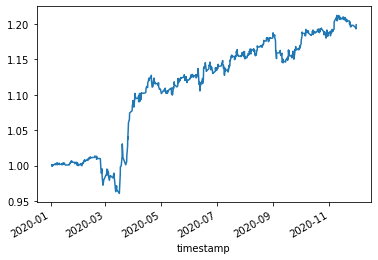

In [38]:
### Plot the +- 10 entry strategies compound returns
row_mask = (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

### **No stops 💎🤲 ** reproduces Isaacs repo no stops results

In [13]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-np.inf]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[np.inf]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask)

100%|██████████| 342/342 [00:46<00:00,  7.34it/s]


In [14]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)

In [15]:
#longresults5_noStop.csv reproduction
longs.groupby('entry').mean().sort_index(ascending=False)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
-10.0,0.0,-inf,0.738839,448.000000,57.082600,0.127417,2.240145,101.015625,45.000000
-15.0,-2.5,-inf,0.731494,410.500000,61.395900,0.150842,2.303659,103.619958,50.000000
-20.0,-5.0,-inf,0.722275,370.333333,28.076900,0.077963,2.223988,106.628030,51.666667
-25.0,-7.5,-inf,0.696034,325.500000,11.477300,0.037436,2.306340,111.641388,57.500000
-30.0,-10.0,-inf,0.694796,298.800000,1.717420,0.003659,2.335175,111.730036,59.000000
-35.0,-12.5,-inf,0.702476,280.166667,20.512850,0.071060,2.375305,110.564901,59.583333
-40.0,-15.0,-inf,0.699352,246.285714,15.352871,0.054391,2.383230,112.428509,62.500000
-45.0,-17.5,-inf,0.684513,221.875000,17.583163,0.069228,2.422158,114.495314,66.875000
-50.0,-20.0,-inf,0.682384,194.333333,12.597522,0.056898,2.430454,117.381276,69.166667


In [16]:
shorts.groupby('entry').mean().sort_index(ascending=True)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
10.0,0.0,inf,0.681818,396.000000,52.723700,0.133141,1.162673,85.909091,40.000000
15.0,2.5,inf,0.675883,348.000000,34.891850,0.100735,1.095223,89.344429,47.500000
20.0,5.0,inf,0.665138,305.666667,29.030333,0.095619,1.038808,91.506542,51.666667
25.0,7.5,inf,0.635152,260.500000,24.035500,0.091839,1.031031,94.945277,52.500000
30.0,10.0,inf,0.656739,246.000000,39.612600,0.163268,1.012147,91.729678,53.000000
35.0,12.5,inf,0.649273,213.833333,34.188000,0.162113,0.975397,93.687230,54.166667
40.0,15.0,inf,0.646313,186.000000,31.176571,0.172145,0.950229,94.569870,54.642857
45.0,17.5,inf,0.655365,163.250000,24.525625,0.155558,0.921894,96.954072,58.437500
50.0,20.0,inf,0.668973,147.888889,24.300556,0.170321,0.907778,96.646108,60.555556


{'num_trades': 844, 'mean_ret': 0.0004736296924633796, 'ret_std': 0.006275445815995963, 'ret_skew': 0.1367921537928899}
0.7109004739336493


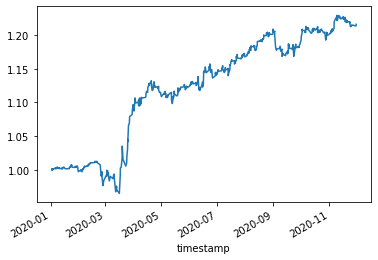

In [17]:
row_mask = (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 45205, 'mean_ret': 0.00032815176863229724, 'ret_std': 0.005928865722834487, 'ret_skew': -0.7642054441156984}
0.6793717509125097


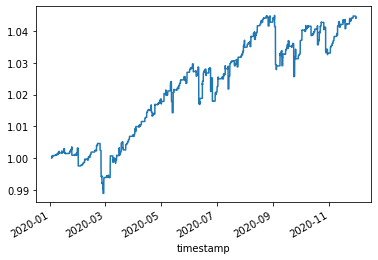

In [21]:
row_mask = (trades.entry.notnull())
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 18472, 'mean_ret': 0.0004483911755120154, 'ret_std': 0.002825834424501036, 'ret_skew': -0.43183799371995457}
0.6692291035080121
{'num_trades': 396, 'mean_ret': 0.0004520333461033069, 'ret_std': 0.003823136572695068, 'ret_skew': -0.040677398157027}
0.6792929292929293


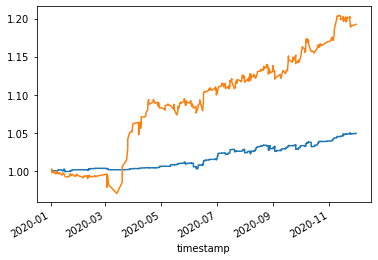

In [22]:
# the shorts dominate
row_mask = (trades.entry > trades.exit)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

row_mask = (trades.entry > trades.exit) & (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 26733, 'mean_ret': 0.00024506860086653993, 'ret_std': 0.007342126819491176, 'ret_skew': -0.6345530167232887}
0.6863801294280477
{'num_trades': 448, 'mean_ret': 0.0004927193200495153, 'ret_std': 0.007832781631094644, 'ret_skew': 0.13152961680248218}
0.7388392857142857


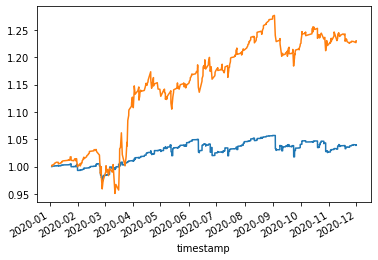

In [23]:
# the shorts dominate
row_mask = (trades.entry < trades.exit)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

row_mask = (trades.entry < trades.exit) & (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 3080, 'mean_ret': 0.00040922576945380995, 'ret_std': 0.006433299522258868, 'ret_skew': 0.21846591742371832}
0.6827922077922078


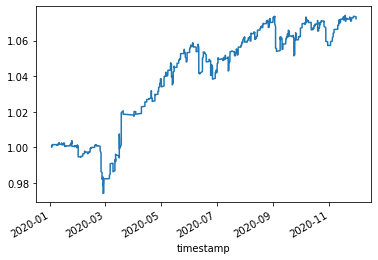

In [24]:
row_mask = (trades.entry.abs() == 50)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

### **No Reentry after going above/below stop unless fall below entry first**

In [25]:
combos = []
### list of [ENTRY, EXIT, STOP] combos to run
combos.extend([list(i) for i in it.product(*[np.arange(-95,-5,5),np.arange(-85,5,5),[-100]]) if ((i[0] < i[1]) & (i[2] < i[0]))])
combos.extend([list(i) for i in it.product(*[np.arange(95,5,-5),np.arange(85,-5,-5),[100]]) if ((i[0] > i[1]) & (i[2] > i[0]))])
combos = [combo for combo in combos if ~((np.abs(combo[0] - combo[1]) < 10))]

results, ensembles, trades = calcAllStrats(strat, combos, mask_func=mrMask_NoReentryFromStopSide)

100%|██████████| 342/342 [00:51<00:00,  6.68it/s]


In [26]:
all_strats = trades.groupby('strat_name').first().loc[:,['entry',	'exit', 'stop',	'success_rate',	'total_trades', 'total_PNL',	'mean_of_returns',	'standard_deviation', 'average_hold_time',	'median_hold_time']]
longs = all_strats.loc[all_strats.entry < 0].sort_values(by=['entry','exit'], ascending=False)
shorts = all_strats.loc[all_strats.entry > 0].sort_values(by='entry', ascending=True)

In [32]:
longs.groupby('entry').mean().sort_index(ascending=False)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
-10,0.0,-100.0,0.615385,572.000000,45.759600,0.079999,1.904100,70.882867,35.000000
-15,-2.5,-100.0,0.600868,534.500000,50.072900,0.094335,1.927981,70.628656,37.500000
-20,-5.0,-100.0,0.583282,494.333333,16.837233,0.035117,1.824143,70.052554,35.000000
-25,-7.5,-100.0,0.550415,449.500000,0.279300,0.001574,1.854565,69.867122,36.250000
-30,-10.0,-100.0,0.534206,422.800000,-9.455580,-0.023669,1.843733,67.031734,34.000000
-35,-12.5,-100.0,0.529190,404.166667,9.356517,0.021590,1.850399,63.844473,33.750000
-40,-15.0,-100.0,0.509673,370.285714,4.208443,0.007238,1.798639,60.552875,32.142857
-45,-17.5,-100.0,0.484334,345.750000,6.447663,0.013831,1.773666,57.966793,30.937500
-50,-20.0,-100.0,0.464557,317.111111,1.813967,0.002216,1.734364,55.201248,30.555556


In [28]:
shorts.groupby('entry').mean().sort_index(ascending=True)

,exit,stop,success_rate,total_trades,total_PNL,mean_of_returns,standard_deviation,average_hold_time,median_hold_time
entry,,,,,,,,,
10,0.0,100.0,0.641723,441.000000,55.161700,0.125083,1.093149,72.539683,35.000000
15,2.5,100.0,0.630312,393.000000,37.329850,0.095340,1.018933,73.849398,40.000000
20,5.0,100.0,0.613933,349.666667,31.468333,0.090464,0.956574,74.007065,41.666667
25,7.5,100.0,0.579637,304.500000,26.473500,0.086564,0.935911,74.148347,41.250000
30,10.0,100.0,0.594934,290.000000,42.050600,0.146444,0.915850,70.319074,40.500000
35,12.5,100.0,0.580953,257.833333,36.626000,0.143391,0.869872,69.176150,40.416667
40,15.0,100.0,0.563815,230.000000,33.614571,0.148959,0.832303,67.106285,36.785714
45,17.5,100.0,0.563151,206.250000,26.243625,0.130219,0.791026,66.039808,38.125000
50,20.0,100.0,0.567581,190.888889,26.100778,0.139822,0.764466,63.152700,34.166667


{'num_trades': 67787, 'mean_ret': 0.00016925130966782432, 'ret_std': 0.00440230208495612, 'ret_skew': 0.4546127297661059}
0.4766400637290336


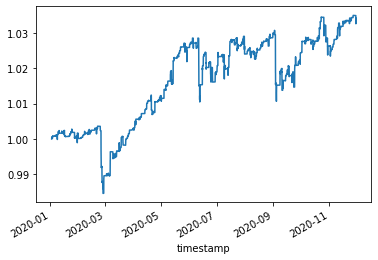

In [29]:
row_mask = (trades.entry.notnull())
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 24413, 'mean_ret': 0.00037562163245032716, 'ret_std': 0.0023589733295735953, 'ret_skew': 0.2660680257453083}
0.5415557285053045
{'num_trades': 441, 'mean_ret': 0.00042146304170024364, 'ret_std': 0.0036054460869922728, 'ret_skew': 0.10987193646607436}
0.6394557823129252


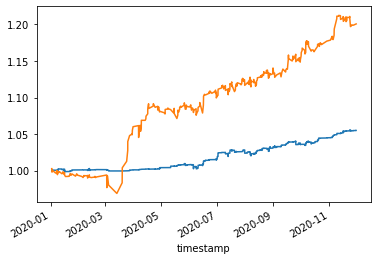

In [30]:
# the shorts dominate
row_mask = (trades.entry > trades.exit)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

row_mask = (trades.entry > trades.exit) & (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

{'num_trades': 43374, 'mean_ret': 5.309603945781705e-05, 'ret_std': 0.005207604867915903, 'ret_skew': 0.4684782940876105}
0.44010236547240283
{'num_trades': 572, 'mean_ret': 0.00032373412487257143, 'ret_std': 0.006730607370964264, 'ret_skew': 0.7563497104818542}
0.6153846153846154


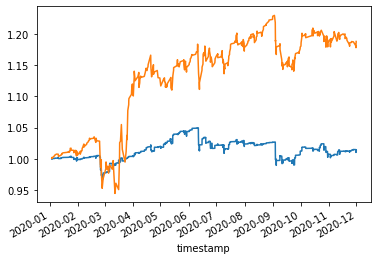

In [31]:
# the shorts dominate
row_mask = (trades.entry < trades.exit)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))

row_mask = (trades.entry < trades.exit) & (trades.entry.abs() <= 10)
plotTradeReturns(trades, row_mask, trade_adjust=len(trades.loc[row_mask,'strat_name'].unique()))